In [5]:
import numpy as np
import matplotlib.pyplot as plt

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation

In [8]:
from nsb import ASSETS_PATH
from nsb.core import Frame, Model
from nsb.instrument import HESS
from nsb.emitter import moon, airglow, galactic, zodiacal, stars
from nsb.atmosphere import scattering, extinction

# Predicting Night Sky Background for H.E.S.S.

## 1.  Creating a model

We create a standard pipeline for HESSI:

In [11]:
# Sources:
glow = airglow.Noll2012({"H": 87})
zodi = zodiacal.Masana2021({})
jons = moon.Jones2013({})
scat = stars.GaiaDR3({'catalog_file':ASSETS_PATH+'gaiadr3.npy', 'magmin':-3, 'magmax':20})
smap = stars.GaiaDR3Mag15({'magnitude_maps':ASSETS_PATH+'gaia_mag15plus.npy'})

# Atmospheric Extinction:
atm_airglow = extinction.Noll2012({'scale':1.6, 'offset':-0.16})([glow])
atm_diffuse = extinction.Masana2021({'gamma':0.5})([zodi])
atm_stellar = extinction.Masana2021({'gamma':1})([scat, smap])

# Atmospheric Scattering:
conf_mie = {"parameters": [0.8],
            "bins": [np.linspace(0, np.pi, 1000)]}      
conf_ray = {"parameters": [0.0148],
            "bins": [np.linspace(0, np.pi, 1000)]}
atm_ray = scattering.Rayleigh(conf_ray)([jons]).map(np.deg2rad(180))
atm_mie = scattering.Mie(conf_mie)([jons]).map(np.deg2rad(180))

# Camera:
CT1 = HESS.CT1(8)([atm_stellar, atm_ray, atm_mie, atm_airglow, atm_diffuse])

### Compiling the model:

In [12]:
%%time
model = Model(CT1)
model.compile()

/home/anonymous/.local/lib/python3.10/site-packages/blacksky/photometric.py:32: RuntimeWarning: invalid value encountered in subtract
  color = magnitudes[j[0]] - magnitudes[j[1]]


CPU times: user 45.1 s, sys: 6.41 s, total: 51.5 s
Wall time: 52 s


### Visualizing the pipeline
Currently, this only prints out the graph, feel free to create your own visualization on top of this.

In [13]:
print(model.summary())

defaultdict(<class 'list'>, {<nsb.instrument.HESS.CT1 object at 0x7f3fb65ad060>: [<nsb.atmosphere.extinction.Masana2021 object at 0x7f3fb65acbe0>, <nsb.atmosphere.scattering.Rayleigh object at 0x7f3fb69f76d0>, <nsb.atmosphere.scattering.Mie object at 0x7f3fb69f45b0>, <nsb.atmosphere.extinction.Noll2012 object at 0x7f3fb6db20e0>, <nsb.atmosphere.extinction.Masana2021 object at 0x7f3fb656fc70>], <nsb.atmosphere.extinction.Masana2021 object at 0x7f3fb65acbe0>: [<nsb.emitter.stars.GaiaDR3 object at 0x7f3fb6db2200>, <nsb.emitter.stars.GaiaDR3Mag15 object at 0x7f3fb6db1bd0>], <nsb.atmosphere.scattering.Rayleigh object at 0x7f3fb69f76d0>: [<nsb.emitter.moon.Jones2013 object at 0x7f3fb6db1ae0>], <nsb.atmosphere.scattering.Mie object at 0x7f3fb69f45b0>: [<nsb.emitter.moon.Jones2013 object at 0x7f3fb6db1ae0>], <nsb.atmosphere.extinction.Noll2012 object at 0x7f3fb6db20e0>: [<nsb.emitter.airglow.Noll2012 object at 0x7f3fb6db0a00>], <nsb.atmosphere.extinction.Masana2021 object at 0x7f3fb656fc70>: [

## 3. Determining a frame to capture:
A "frame" describing a capture is determined by:
 - A location
 - An observation time in UTC
 - A target at which to point
 
Additionally, this includes
 - The fov radius in which to query stars
 - The rotation of the telescope around the axis
 - The wavelengths at which to evaluate
 - The single scattering aerosol albedo
 - The aeronet values for 380nm
 - The solar flux in SFU (value ideally from 4.5 days before observation)

In [14]:
location = EarthLocation.from_geodetic(16.5028, -23.27280, 1800.)
obstime  = astropy.time.Time('2021-03-21T22:14:16', format='isot', scale='utc')
target   = SkyCoord.from_name('eta car')

frame = Frame(location, obstime, target, 3.2, -0.25*u.deg, np.linspace(270, 730, 30)*u.nm, albedo=0.85, aero=[0.065, 1.2], sfu=75)

## 4. Using the model to predict NSB
Calling the model is then easy:

In [15]:
%%time
res = model.predict(frame)

CPU times: user 1.62 s, sys: 365 ms, total: 1.99 s
Wall time: 2.01 s


## 5. Visualizing the data:
Visualization is easiest with ctapipe (which you should install for this to work):

In [18]:
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
cam = CameraGeometry.from_name('HESS-I')
def ctapipe_disp(cam, instrument, rays, ax, label='a.u.', **kwargs):
    display = CameraDisplay(cam, ax=ax, **kwargs)
    display.image = instrument.camera.pix_assign(rays)
    display.add_colorbar(label=label)
    return display

/home/anonymous/.local/lib/python3.10/site-packages/ctapipe/instrument/camera/geometry.py:616: FromNameWarning: .from_name uses pre-defined data that is likely different from the data being analyzed. Access instrument information via the SubarrayDescription instead.
  warn_from_name()


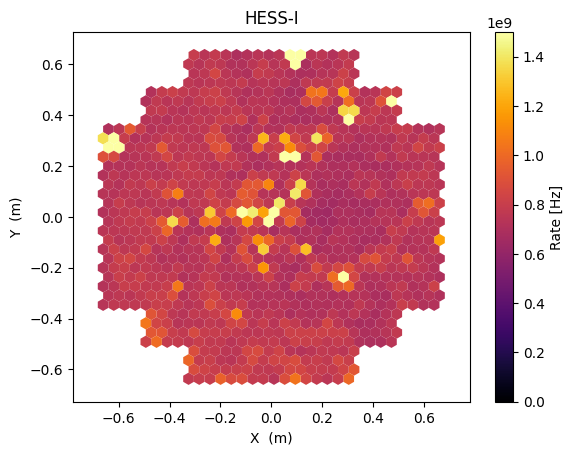

In [28]:
fig, ax = plt.subplots()
disp = ctapipe_disp(cam, CT1, res, ax, 'Rate [Hz]', show_frame=False)
disp.set_limits_minmax(0, 1.5e9)

### Individual contributions:

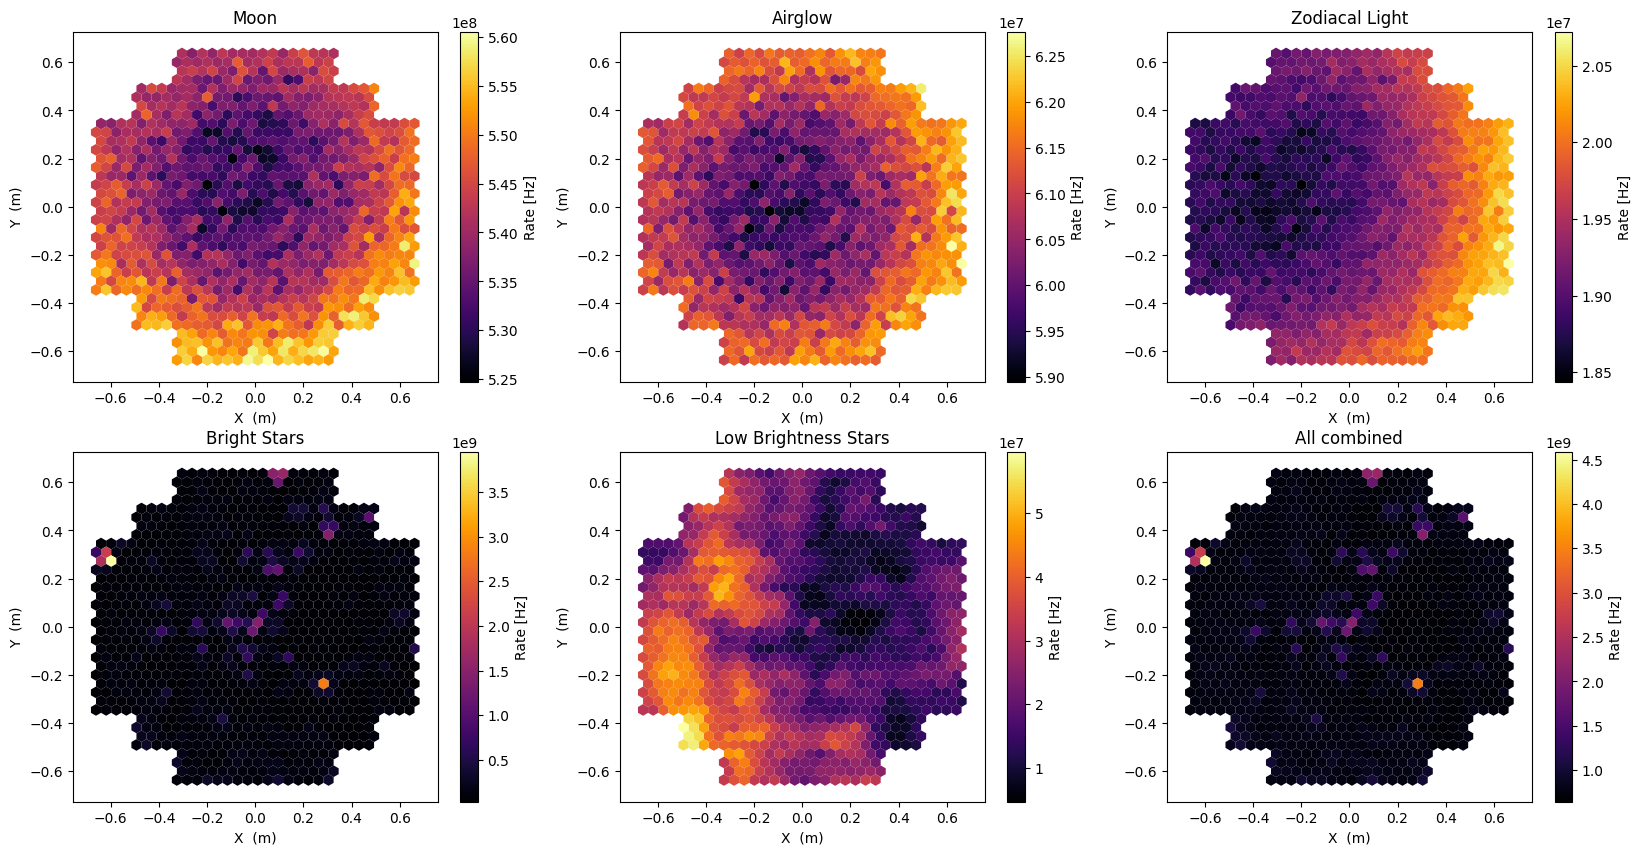

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
disp1 = ctapipe_disp(cam, CT1, res[res.source == type(jons)], ax[0,0], 'Rate [Hz]', title='Moon', show_frame=False)
disp2 = ctapipe_disp(cam, CT1, res[res.source == type(glow)], ax[0,1], 'Rate [Hz]', title='Airglow', show_frame=False)
disp3 = ctapipe_disp(cam, CT1, res[res.source == type(zodi)], ax[0,2], 'Rate [Hz]', title='Zodiacal Light', show_frame=False)
disp4 = ctapipe_disp(cam, CT1, res[res.source == type(scat)], ax[1,0], 'Rate [Hz]', title='Bright Stars', show_frame=False)
disp5 = ctapipe_disp(cam, CT1, res[res.source == type(smap)], ax[1,1], 'Rate [Hz]', title='Low Brightness Stars', show_frame=False)
disp6 = ctapipe_disp(cam, CT1, res, ax[1,2], 'Rate [Hz]', title='All combined', show_frame=False)